Attention Layer with Contrastive Learning

In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns
import pickle
from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from data.utils import SimpleDataset, SimpleDataset_masked

from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN
from utils.trainer_helpers import batch_t_categorize, wt_avg, attention_mask


In [3]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch ESSA Training')
parser.add_argument('--dataset', default='SUPPORT', help='dataset setting')
parser.add_argument('-s',  default=16, type=int, help='embedding dimensions')
parser.add_argument('-nbin', default=100, type=int, help='discrete bins for time-to-event')

# parser.add_argument('--loss_type', default="MSE", type=str, help='point estimation loss type')
parser.add_argument('--loss_type',
                    default='MSE',
                    const='MSE',
                    nargs='?',
                    choices=['MSE', 'MAE', 'RAE'],
                    help='point estimation loss type (default: MSE)')

parser.add_argument('--percentile', default="True", type=str, help='time line discretize method')
parser.add_argument('--event_based', default="False", type=str, help='based on event timeline')
parser.add_argument('--num_try', default="0", type=str, help='number of try for the same architecture')


parser.add_argument('-enc_dim', nargs='+', type=int, default=[32,32],
                    help='encoder structure')
parser.add_argument('-dec_dim', nargs='+', type=int, default=[32,32],
                    help='decoder structure')

parser.add_argument('--emb_lr', default=1e-4, type=float,
                    metavar='EMBLR', help='learning rate for embedding network')
parser.add_argument('--clf_lr', default=1e-3, type=float,
                    metavar='CLFLR', help='learning rate for contrastive network')
parser.add_argument('--dec_lr', default=1e-4, type=float,
                    metavar='DECLR', help='learning rate for decoding network')

parser.add_argument('--ct_wt', default=1, type=float, help='weight for contrastive loss')
parser.add_argument('--pt_wt', default=0, type=float, help='weight for point estimation loss')

parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--continue_training', default='False', type=str,
                    help='continue training on the last best epoch')
parser.add_argument('-batch_size', default=128, type=int,
                    metavar='N',
                    help='mini-batch size')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=2e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=100, type=int,
                    metavar='N', help='print frequency (default: 100)')

parser.add_argument('--result_path_root', '--wording-dir',default='', type=str, metavar='PATH',
                    help='path to the result files')
parser.add_argument('--file_path',default='', type=str, metavar='FILEPATH',
                    help='path to the data files')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')

parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--num_gpu', default=2, type=int,
                    help='number of GPU cores.')
parser.add_argument('--gpu', default=0, type=int,
                    help='GPU id to use.')

# to run argparse without command line
import sys
sys.argv = ['']

global args
args = parser.parse_args()


In [4]:
args.enc_dim

[32, 32]

In [5]:
file_path='/data/zidi/cVAE/datasets/'
result_path_root = '/data/zidi/ACSurv/results/SUPPORT'

args.result_path_root = result_path_root
args.file_path = file_path
args.model_name = 'ELSSA'

args.num_try = 1

# args.percentile = 'True'
# args.event_based = 'False'


event_based = 'event' if args.event_based == 'True' else 'all'
percentile = 'percentile' if args.percentile == 'True' else 'linespace'

args.store_name = '_'.join([args.model_name, args.dataset,\
                            event_based,percentile, 'nbin', str(args.nbin),\
                            'emb', str(args.s),\
                            'enc', '_'.join([str(dim) for dim in args.enc_dim]),\
                            'dec', '_'.join([str(dim) for dim in args.dec_dim]),\
                           'ctWt', str(args.ct_wt), 'ptWt', str(args.pt_wt), args.num_try])

args.store_name

'ELSSA_SUPPORT_all_percentile_nbin_100_emb_16_enc_32_32_dec_32_32_ctWt_1_ptWt_0_0'

## support Dataset

Load flchain dataset

In [6]:
from data.support_data import generate_data
file_path='/data/zidi/cVAE/datasets/'
result_path_root = '/data/zidi/ACSurv/results/SUPPORT'

train, valid, test, variable_info = generate_data(file_path = args.file_path, m=args.s)
train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

num_examples:7284
x_shape:(9105, 35)
end_time:2029
observed percent:0.6810543657331136
test:910, valid:911, train:7284, all: 9105
observed fold:0.6832784184514004
observed fold:0.6681318681318681
observed fold:0.6761800219538968


In [7]:
cov_list, cts_var, cts_idx, cat_var, cat_idx = variable_info['cov_list'], variable_info['cts_var'], variable_info['cts_idx'], variable_info['cat_var'], variable_info['cat_idx']

In [8]:
cov_list, cts_var, cat_var

(array(['age', 'sex', 'slos', 'dzgroup', 'dzclass', 'num_co', 'edu',
        'income', 'scoma', 'charges', 'totcst', 'avtisst', 'race', 'hday',
        'diabetes', 'dementia', 'ca', 'meanbp', 'wblc', 'hrt', 'resp',
        'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose',
        'bun', 'urine', 'adlp', 'adls', 'sfdm2', 'adlsc'], dtype='<U8'),
 array(['age', 'slos', 'num_co', 'edu', 'scoma', 'charges', 'totcst',
        'avtisst', 'hday', 'diabetes', 'dementia', 'meanbp', 'wblc', 'hrt',
        'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
        'glucose', 'bun', 'urine', 'adlp', 'adls', 'adlsc'], dtype='<U8'),
 array(['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'sfdm2'],
       dtype='<U8'))

In [9]:
x_landmarks, x_levels = variable_info['x_landmarks'], variable_info['x_levels']
x_landmarks, x_levels

(None, None)

In [10]:
if args.event_based == 'True':
    train_time = train['t'][train['e']==1]
else:
    train_time = train['t']
    
    
if args.percentile == 'True':
    '''based on each covariate percentile'''
    t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,args.s))).contiguous()
    tt = np.percentile(train_time,np.linspace(0.,100.,args.nbin, endpoint=True))

else:
    '''based on the each covariate range'''
    t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),args.s, endpoint=True)).contiguous()
    tt = np.linspace(np.min(train_time),np.max(train_time),args.nbin, endpoint=True)


# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    args.nbin = args.nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)

t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
t_all_max, t_max, loss_of_info

(2029.0, 1944.0, 0.015650741350906095)

101

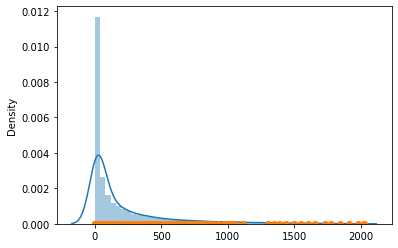

In [11]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')
len(tt)

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [12]:
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.ContrastiveLearning import FDV_CL
from model.SimpleNN import *



In [13]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset_masked(train['x'], train['t'], train['e'], train['missing_mask'])
pair1 = DataLoader(trainData, batch_size=args.batch_size,shuffle=True)

validData = SimpleDataset_masked(valid['x'], valid['t'], valid['e'], valid['missing_mask'])
v_pair1 = DataLoader(validData, batch_size=args.batch_size,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

testData = SimpleDataset_masked(test['x'], test['t'], test['e'], test['missing_mask'])
t_pair1 = DataLoader(testData, batch_size=args.batch_size,shuffle=True)


In [14]:
args.result_path_root

'/data/zidi/ACSurv/results/SUPPORT'

In [71]:
# args.continue_training = 'True'

In [72]:
zdim = args.s
epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = args.gpu
n_gpu = args.num_gpu
all_device = set(np.arange(args.num_gpu))
all_device.remove(args.gpu)
device_ids = [args.gpu] + list(all_device)

torch.cuda.set_device(device_name)

# point estimation loss function and weight
# loss_type = args.loss_type
# lambda_ = args.pt_wt
# ctr_wt = args.ct_wt
# bined time
tt = torch.tensor(tt).to(device)

result_path = args.result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

plot_path = args.result_path_root+'/plots/'
Path(plot_path).mkdir(parents=True, exist_ok=True)

pickle.dump( args, open( result_path+args.store_name+"_args.pkl", "wb" ) )

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)
'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)

emb_path = result_path+args.store_name+'_emb'+'.pt'
dec_path = result_path+args.store_name+'_dec'+'.pt'
att_path = result_path+args.store_name+'_att'+'.pt'
clf_path = result_path+args.store_name+'_clf'+'.pt'


if args.continue_training == 'True':
    embedding.load_state_dict(torch.load(emb_path))
    attention.load_state_dict(torch.load(att_path))
    clf.load_state_dict(torch.load(clf_path))
    decoder.load_state_dict(torch.load(dec_path))
    
# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=args.emb_lr)
opt_dec = optim.Adam(decoder.parameters(), lr=args.dec_lr)
opt_clf = optim.Adam(clf.parameters(), lr=args.clf_lr)

# opt_emb = torch.optim.SGD(embedding.parameters(), args.emb_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# opt_dec = torch.optim.SGD(decoder.parameters(), args.dec_lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.weight_decay)

# define scheduler
emb_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_emb, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_dec, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)
clf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_clf, mode='min', factor=0.1, patience=5, min_lr=0, verbose=True)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)



# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (age): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (slos): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (num_co): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (edu): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (scoma): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (charges): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (totcst): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (avtisst): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (hday): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (diabetes): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (dementia): Parameter containing: [torch.cuda.FloatTensor of size 16x16 (GPU 0)]
      (meanbp): Paramet

epoch1


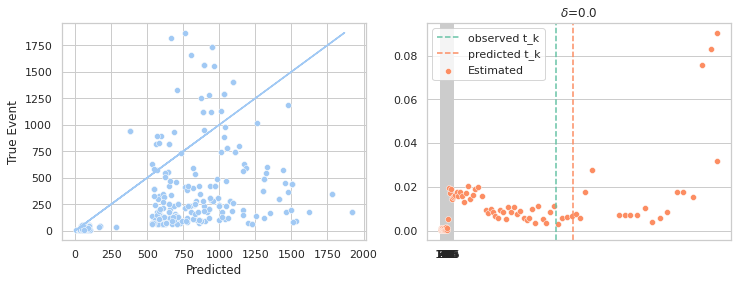

====> Train NLL: 2.800 	 Valid NLL: 2.687 CI: 0.833 event loss: 145714.021 	 censoring loss : 60679.858 	 Improved: *
epoch2


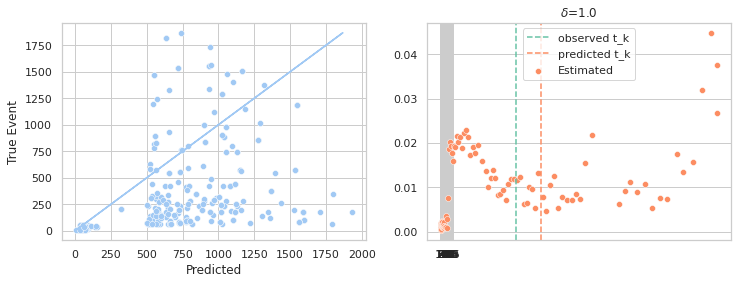

====> Train NLL: 2.796 	 Valid NLL: 2.670 CI: 0.838 event loss: 148080.080 	 censoring loss : 58535.972 	 Improved: *
epoch3
====> Train NLL: 2.790 	 Valid NLL: 2.670 CI: 0.833 event loss: 150966.305 	 censoring loss : 58014.744 	 Improved:  
epoch4


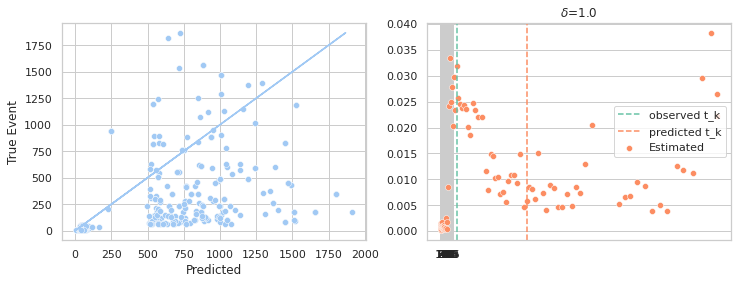

====> Train NLL: 2.777 	 Valid NLL: 2.667 CI: 0.833 event loss: 139788.422 	 censoring loss : 62887.638 	 Improved: *
epoch5
====> Train NLL: 2.772 	 Valid NLL: 2.662 CI: 0.831 event loss: 140161.481 	 censoring loss : 62379.194 	 Improved:  
epoch6


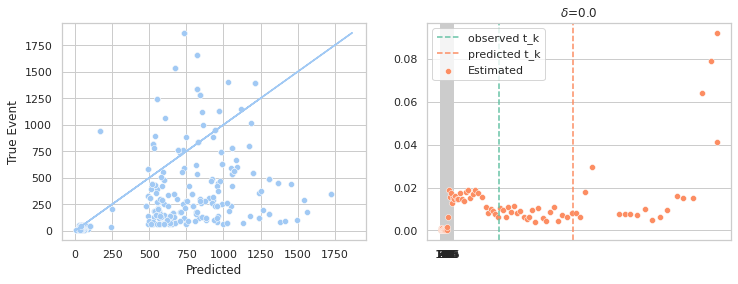

====> Train NLL: 2.768 	 Valid NLL: 2.659 CI: 0.836 event loss: 127740.307 	 censoring loss : 68070.880 	 Improved: *
epoch7
====> Train NLL: 2.766 	 Valid NLL: 2.653 CI: 0.831 event loss: 155185.264 	 censoring loss : 57683.313 	 Improved:  
epoch8
====> Train NLL: 2.769 	 Valid NLL: 2.650 CI: 0.829 event loss: 170683.177 	 censoring loss : 51040.258 	 Improved:  
epoch9


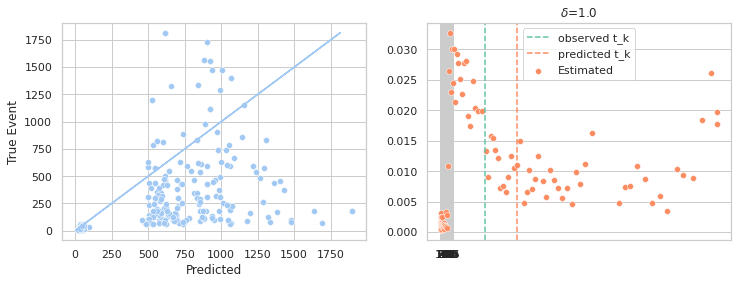

====> Train NLL: 2.748 	 Valid NLL: 2.647 CI: 0.838 event loss: 130645.847 	 censoring loss : 66560.490 	 Improved: *
epoch10
====> Train NLL: 2.740 	 Valid NLL: 2.639 CI: 0.835 event loss: 142314.304 	 censoring loss : 59998.354 	 Improved:  
epoch11


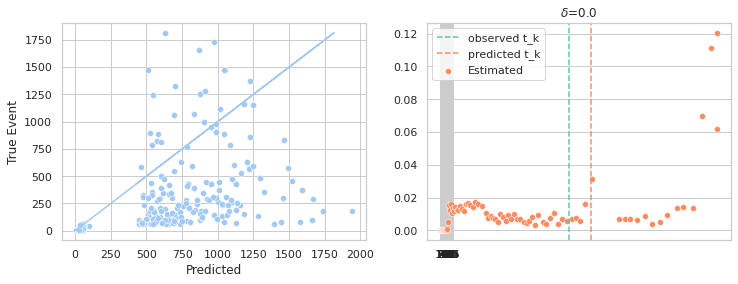

====> Train NLL: 2.741 	 Valid NLL: 2.632 CI: 0.839 event loss: 147729.661 	 censoring loss : 58804.366 	 Improved: *
epoch12
====> Train NLL: 2.738 	 Valid NLL: 2.637 CI: 0.834 event loss: 132914.738 	 censoring loss : 67421.614 	 Improved:  
epoch13
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
====> Train NLL: 2.727 	 Valid NLL: 2.633 CI: 0.828 event loss: 162429.628 	 censoring loss : 54144.200 	 Improved:  
epoch14


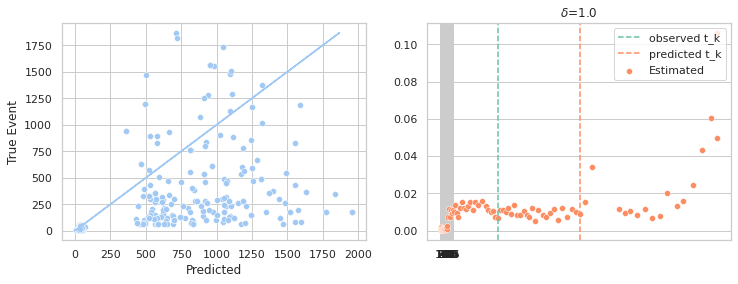

====> Train NLL: 2.723 	 Valid NLL: 2.618 CI: 0.841 event loss: 160185.959 	 censoring loss : 52463.288 	 Improved: *
epoch15


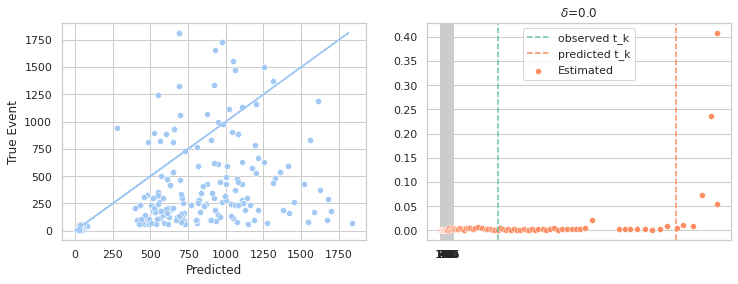

====> Train NLL: 2.723 	 Valid NLL: 2.619 CI: 0.845 event loss: 154333.925 	 censoring loss : 55427.126 	 Improved: *
epoch16


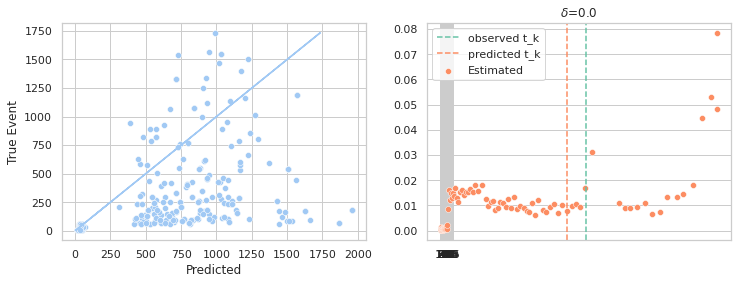

====> Train NLL: 2.726 	 Valid NLL: 2.616 CI: 0.837 event loss: 150834.525 	 censoring loss : 56428.675 	 Improved: *
epoch17
====> Train NLL: 2.716 	 Valid NLL: 2.616 CI: 0.842 event loss: 151090.104 	 censoring loss : 56573.412 	 Improved:  
epoch18


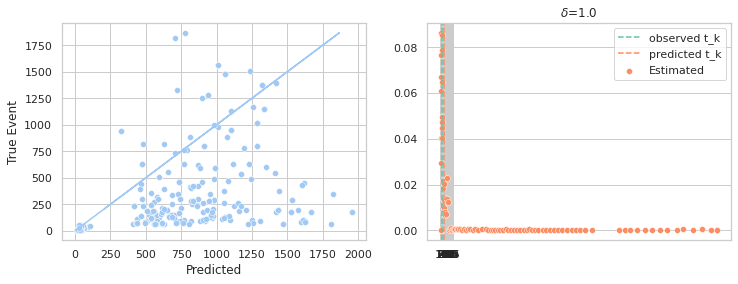

====> Train NLL: 2.699 	 Valid NLL: 2.612 CI: 0.846 event loss: 156397.872 	 censoring loss : 54164.874 	 Improved: *
epoch19
====> Train NLL: 2.708 	 Valid NLL: 2.608 CI: 0.845 event loss: 159290.893 	 censoring loss : 53482.928 	 Improved:  
epoch20
====> Train NLL: 2.710 	 Valid NLL: 2.605 CI: 0.843 event loss: 157381.768 	 censoring loss : 54875.409 	 Improved:  
epoch21


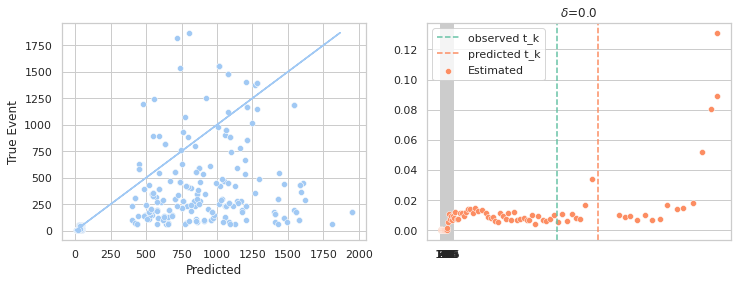

====> Train NLL: 2.702 	 Valid NLL: 2.601 CI: 0.844 event loss: 151306.363 	 censoring loss : 56043.950 	 Improved: *
epoch22
====> Train NLL: 2.694 	 Valid NLL: 2.601 CI: 0.846 event loss: 151350.887 	 censoring loss : 56816.263 	 Improved:  
epoch23
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.


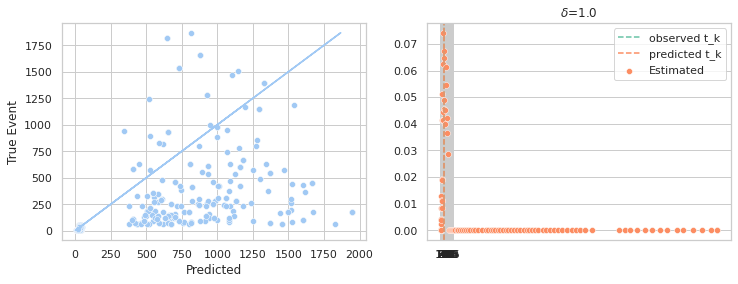

====> Train NLL: 2.689 	 Valid NLL: 2.595 CI: 0.846 event loss: 153442.565 	 censoring loss : 55612.231 	 Improved: *
epoch24


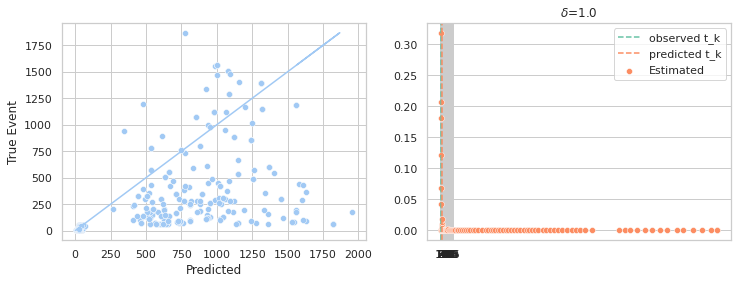

====> Train NLL: 2.677 	 Valid NLL: 2.595 CI: 0.848 event loss: 149264.652 	 censoring loss : 56407.584 	 Improved: *
epoch25
====> Train NLL: 2.687 	 Valid NLL: 2.591 CI: 0.846 event loss: 153031.044 	 censoring loss : 55902.616 	 Improved:  
epoch26
====> Train NLL: 2.688 	 Valid NLL: 2.589 CI: 0.848 event loss: 154938.741 	 censoring loss : 55351.704 	 Improved:  
epoch27
====> Train NLL: 2.689 	 Valid NLL: 2.592 CI: 0.846 event loss: 150623.059 	 censoring loss : 56528.985 	 Improved:  
epoch28


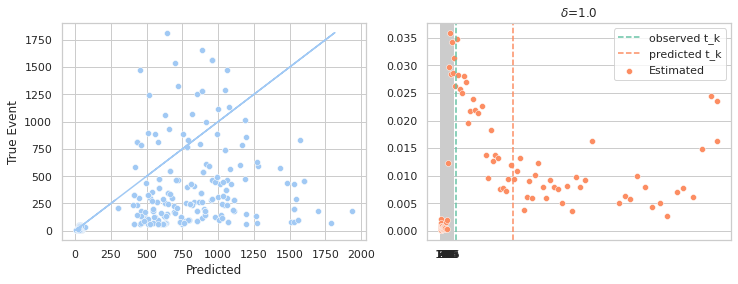

====> Train NLL: 2.682 	 Valid NLL: 2.589 CI: 0.849 event loss: 140569.024 	 censoring loss : 59215.987 	 Improved: *
epoch29
Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 2.677 	 Valid NLL: 2.590 CI: 0.847 event loss: 152736.686 	 censoring loss : 55266.861 	 Improved:  
epoch30
====> Train NLL: 2.682 	 Valid NLL: 2.584 CI: 0.847 event loss: 149432.207 	 censoring loss : 56675.372 	 Improved:  
epoch31
====> Train NLL: 2.685 	 Valid NLL: 2.589 CI: 0.847 event loss: 154590.163 	 censoring loss : 55061.322 	 Improved:  
epoch32
====> Train NLL: 2.691 	 Valid NLL: 2.586 CI: 0.849 event loss: 146640.886 	 censoring loss : 56941.295 	 Improved:  
epoch33
====> Train NLL: 2.672 	 Valid NLL: 2.587 CI: 0.849 event loss: 157868.311 	 censoring loss : 53663.331 	 Improved:  
epoch34
====> Train NLL: 2.677 	 Valid NLL: 2.586 CI: 0.849 event loss: 150939.527 	 censoring loss : 56612.701 	 Improved:  
epoch35
Epoch    35: reducing learning rate of group 0 to 1.0000

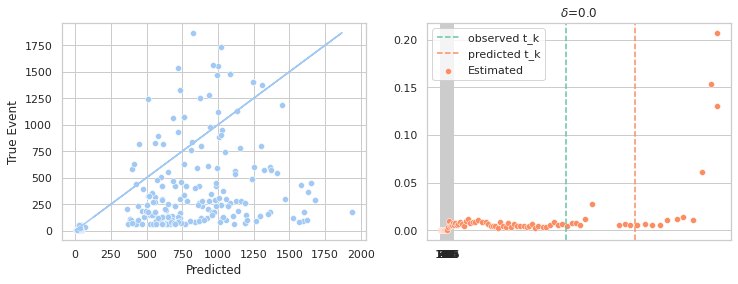

====> Train NLL: 2.676 	 Valid NLL: 2.581 CI: 0.850 event loss: 149904.285 	 censoring loss : 56201.093 	 Improved: *
epoch41
Epoch    41: reducing learning rate of group 0 to 1.0000e-08.
====> Train NLL: 2.686 	 Valid NLL: 2.583 CI: 0.849 event loss: 147761.056 	 censoring loss : 56601.332 	 Improved:  
epoch42
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.
====> Train NLL: 2.675 	 Valid NLL: 2.589 CI: 0.848 event loss: 154745.008 	 censoring loss : 55255.290 	 Improved:  
epoch43
====> Train NLL: 2.670 	 Valid NLL: 2.580 CI: 0.848 event loss: 155115.935 	 censoring loss : 55095.129 	 Improved:  
epoch44
====> Train NLL: 2.674 	 Valid NLL: 2.583 CI: 0.849 event loss: 152446.585 	 censoring loss : 55145.679 	 Improved:  
epoch45
====> Train NLL: 2.681 	 Valid NLL: 2.581 CI: 0.847 event loss: 151365.882 	 censoring loss : 56327.622 	 Improved:  
epoch46
Epoch    46: reducing learning rate of group 0 to 1.0000e-06.
====> Train NLL: 2.680 	 Valid NLL: 2.583 CI: 0.847 event 

In [73]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []
valid_lost_ctr_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
    clf.train()
    decoder.train()


    for i, (x, y, e, mask) in enumerate(pair1):
#         print(i)
        # training encoder and decoder
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
            
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        # when certain observation is missed, the corresponding mask is 0
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + args.pt_wt*loss_est

        # update parameters
        loss = surv_loss + args.ct_wt*loss_infoNCE
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += loss_infoNCE.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    clf.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_ct_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e, mask) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb, var_list = embedding(x)
        
        # re-indexing mask
        reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list])
        mask_new = torch.index_select(mask, 1, reindex)
        del mask
        mask_attn = attention_mask(mask_new, ncov, p=0.1) 
        
        del mask_new
        z, attn_score = attention(x_emb, mask = mask_attn)
        del mask_attn
        
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.module.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        # save one subject for plotting
        subj = np.random.choice(len(e))
        subj_res = t_wa_hat[subj].squeeze().detach().cpu().item(), p_raw[subj].detach().cpu().numpy(), y[subj].detach().cpu().item(), e[subj].detach().cpu().item()
        
        eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + args.pt_wt*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        valid_ct_loss += loss_infoNCE.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze().detach().cpu().numpy())
        valid_t.append(y.squeeze().detach().cpu().numpy())
        valid_e.append(e.squeeze().detach().cpu().numpy())
        del t_wa_hat, y, e, loss, loss_NLL, loss_est, eloss, closs, loss_infoNCE
    
    # try scheduler
    emb_scheduler.step(valid_NLL_loss)
    clf_scheduler.step(valid_ct_loss)
    dec_scheduler.step(valid_est_loss)
        
    # concatenate all the validation results
    valid_e = np.concatenate(valid_e)
    valid_t = np.concatenate(valid_t)
    valid_pred_t = np.concatenate(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t, torch_object=False)[0]
    
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    valid_lost_ctr_hist.append(valid_ct_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1


    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
        torch.save(clf.module.state_dict(), clf_path)
        torch.save(decoder.module.state_dict(), dec_path)
        torch.save(attention.module.state_dict(), att_path)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        r_idx = np.random.choice(np.where(valid_e==1)[0],500)
        sns.scatterplot(valid_pred_t[r_idx], valid_t[r_idx])
        plt.plot(valid_t[r_idx], valid_t[r_idx])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        
        plt.subplot(1, 2, 2)
        t_hat, p_raw, true_t, event_type = subj_res
        plt.axvline(true_t,linestyle='--',color=emp_color,label='observed t_k')
        plt.axvline(t_hat,linestyle='--',color=pred_color,label='predicted t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw, label='Estimated', color=pred_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(event_type))
        plt.show()


        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    del valid_t, valid_e, valid_pred_t
    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

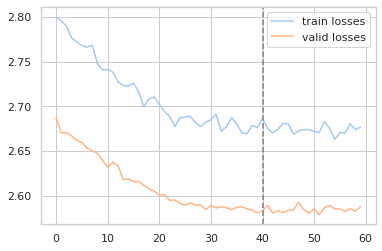

In [74]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.axvline(best_epoch, color='gray',linestyle='--')
plt.legend()

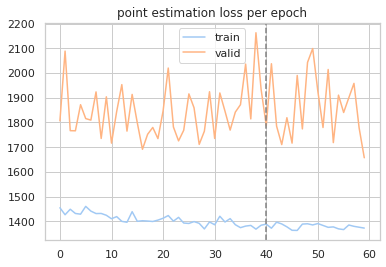

In [75]:
plt.plot(train_loss_est_hist,label="train")
plt.plot(valid_loss_est_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('point estimation loss per epoch')

plt.legend()

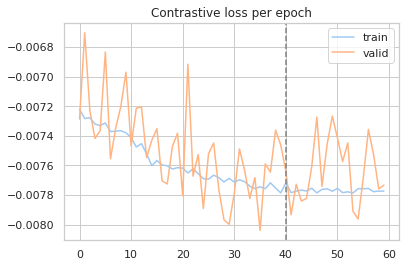

In [76]:
plt.plot(train_lost_ctr_hist,label="train")
plt.plot(valid_lost_ctr_hist,label="valid")
plt.axvline(best_epoch, color='gray',linestyle='--')

plt.title('Contrastive loss per epoch')

plt.legend()

In [77]:

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, x_landmarks, x_levels, m=args.s, dataset=train)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)
'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = args.s, ncov = ncov, t_landmarks = t_landmarks, h_dim=args.enc_dim)


'''decoding the embedded vectors'''
decoder = DecMLP_bin(input_size = zdim, output_size = args.nbin, h_dim=args.dec_dim)


embedding.load_state_dict(torch.load(emb_path))
attention.load_state_dict(torch.load(att_path))
clf.load_state_dict(torch.load(clf_path))
decoder.load_state_dict(torch.load(dec_path))


# put models on device 0
embedding.to(device)
clf.to(device)
attention.to(device)
decoder.to(device)


decoder = nn.DataParallel(decoder, device_ids=device_ids)
attention = nn.DataParallel(attention, device_ids=device_ids)
clf = nn.DataParallel(clf, device_ids=device_ids)



In [78]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

Text(0.5, 1.0, 'AGE embedding')

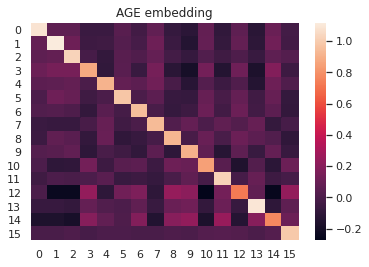

In [79]:
ax = sns.heatmap(embedding.x_emb_landmarks['age'].detach().cpu().numpy())
plt.title('AGE embedding')

### Evaluating performance on testing dataset

In [80]:
from utils.metrics import NLL_reg, point_loss, get_CI_raw, pair_Ctd_DLN


embedding.eval()
decoder.eval()
clf.eval()
attention.eval()


test_e_loss = test_c_loss= 0
test_pred_t = []
test_pred_raw = []
test_t = []
test_e = []
# test_x = []
for i, (x, y, e, mask) in enumerate(t_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)
    mask = mask.to(device)
    
    x_emb, var_list = embedding(x.float())

    # re-indexing mask
    reindex = torch.tensor([np.where(cov_list==var)[0][0] for var in var_list]).to(device)
    mask_new = torch.index_select(mask, 1, reindex)
    del mask
    mask_attn = torch.ones(len(mask_new), ncov, ncov).to(device)-torch.diag(torch.ones(ncov)).unsqueeze(0).repeat(len(mask_new),1,1).to(device)+torch.vstack([torch.diag(mask_new[idx]).unsqueeze(0) for idx in range(len(mask_new))])
    del mask_new
    z, attn_score = attention(x_emb, mask = mask_attn)
    del mask_attn
 
    p_raw = decoder(clf.module.enc(z))

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, args.loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + args.pt_wt*loss_est
    
#     test_x.append(x)
    test_pred_raw.append(p_raw.detach().cpu())
    test_pred_t.append(t_wa_hat.squeeze().detach().cpu())
    test_t.append(y.squeeze().detach().cpu())
    test_e.append(e.squeeze().detach().cpu())
    test_e_loss += eloss.item()

    test_c_loss += closs.item()

print(test_e_loss/len(test['e']))


143503.62890180314


Text(0.5, 1.0, 'Attention Score')

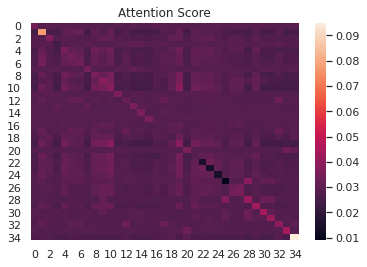

In [81]:
attn_score_avg = attn_score.mean(axis=0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')

In [82]:
# def NLL_reg(p_raw, y, e, tt, collapsed=True):
#     # using likelihood to regularize the performance
#     y_cat = batch_t_categorize(torch.tensor(y).to('cpu'), torch.tensor(e).to('cpu'), tt.to('cpu'))
#     #         keep_idx = torch.where(y <= t_max)[0]
    
#     if collapsed:
#         y_loglikeli = -((p_raw*y_cat).sum(axis=1)+1e-6).log().sum()
#     else:
#         y_loglikeli = -((p_raw*y_cat).sum(axis=1)+1e-6).log()
#     #  -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
    
#     return y_loglikeli

tensor(2.6339)

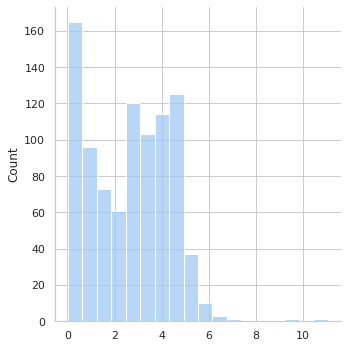

In [83]:
test_pred_raw = torch.cat(test_pred_raw)
test_e = torch.cat(test_e)
test_t = torch.cat(test_t)
test_pred_t = torch.cat(test_pred_t)
# test_x = torch.cat(test_x)
test_likeli = NLL_reg(test_pred_raw, test_t, test_e, tt, collapsed=False)
sns.displot(test_likeli.cpu().detach().numpy())
test_likeli.mean()


In [84]:
def I_Ctd_DLN(t, e, test_pred_prob, tt, i,j):
#     x_i = x[i]
#     x_j = x[j]
    t_true_i = t[i]
    t_i_idx = torch.where(batch_t_categorize(t[i].reshape([1,1]), e[i].reshape([1,1]), tt)[-1]==1)[0]
    sum_idx = torch.cat([torch.ones(t_i_idx), torch.zeros(len(tt)-t_i_idx)])
#     print(test_pred_prob[i], sum_idx)
    F_i = torch.dot(test_pred_prob[i].squeeze(), sum_idx)
    F_j = torch.dot(test_pred_prob[j].squeeze(), sum_idx)
    return(1*(F_i > F_j).cpu().detach().item())
    # return (log_S_i, log_S_j)

def pair_Ctd_DLN(t, e, test_pred_prob, tt):
    j_pool = []
    while len(j_pool)==0:
        subj_i = np.random.choice(torch.where(e==1)[0],1)
        j_pool = torch.where(t>t[subj_i])[0]
        
    subj_j = np.random.choice(torch.where(t>t[subj_i])[0],1)
        
    return(I_Ctd_DLN(t, e, test_pred_prob, tt, subj_i,subj_j))

In [85]:
ACSurv_Ctd = [pair_Ctd_DLN(test_t.to('cpu'), test_e.to('cpu'), test_pred_raw.to('cpu'), tt.to('cpu')) for k in np.arange(10000)]
np.mean(ACSurv_Ctd)

0.7855

0.8451981195433177

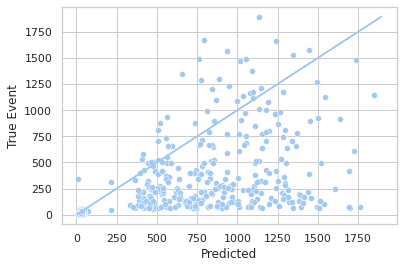

In [86]:

plt.figure()

sns.scatterplot(test_pred_t[test_e==1].cpu().detach().numpy().squeeze(), test_t[test_e==1].cpu())
plt.plot(test_t[test_e==1].cpu(), test_t[test_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')

# plt.xlim(0,200)
# plt.ylim(0,200)

test_CI = get_CI_raw(test_e, test_t, test_pred_t, torch_object=True)[0]
test_CI


In [87]:
from utils.metrics import calculate_coverage, calculate_coverage_censor

In [88]:
# load previous results
old_dir = '/data/zidi/cVAE/results/support'
def loadResults(session_name, out_dir):
    test_pred_prob = np.load(out_dir+'/{}_test_pred_prob'.format(session_name)+'.npy')
    test_loglikeli = np.load(out_dir+'/{}_test_loglikeli'.format(session_name)+'.npy')
    return  test_pred_prob, test_loglikeli
VSI_pred_prob, VSI_loglikeli= loadResults('cVAE_q_support_107', old_dir )
VSI_pred_medt = np.load(old_dir +'/{}_test_pred_medt'.format('cVAE_q_support_107')+'.npy')
VSI_pred_avgt = np.load(old_dir +'/{}_test_pred_avgt'.format('cVAE_q_support_107')+'.npy')
VSI_pred_randomt = np.load(old_dir +'/{}_test_pred_randomt'.format('cVAE_q_support_107')+'.npy')
VSI_tt = np.load(old_dir +'/{}_tt'.format('cVAE_q_support_107')+'.npy')


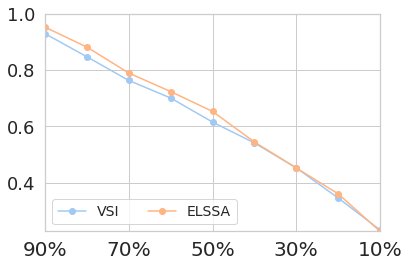

In [89]:
quantile_list = np.delete(np.linspace(0,0.5,10, endpoint=False),0)
quantiles_list = [[q, 1.-q]for q in quantile_list]
select_idx = (test_e.numpy()==1)
model_coverage =  [np.mean(calculate_coverage(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]

select_idx = test['e']==1
VSI_coverage =  [np.mean(calculate_coverage(VSI_pred_prob[select_idx], VSI_tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

sns.set(style="whitegrid", palette="pastel", color_codes=True)


plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

# plt.plot(RSF_coverage, label = 'RSF', color = RSFcolor)


# plt.xticks([0.5,4,7.5],['[0.05,0.95]', '[0.25,0.75]', '[0.45,0.55]'],size=20, rotation=0)#, rotation=25)
# plt.yticks([0.2,0.4,0.6,0.8],size=15)#, rotation=25)

plt.margins(0,0)
plt.legend(prop={'size': 14},ncol=2,loc='lower right')

plt.xticks([0,2,4,6,8],['90%', '70%', '50%', '30%','10%'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.4,0.6,0.8,1.0],size=18)#, rotation=25)

plt.legend(prop={'size': 14},ncol=2,loc='lower left')

# plt.title('covarage rate for censoring\n'+'SUPPORT Dataset')

# plt.savefig(plot_path + '/SUPPORT_e_coverage.pdf', tight_layout = True)


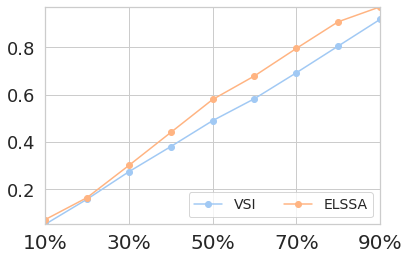

In [91]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

quantiles_list = np.delete(np.linspace(0,1.0,10, endpoint=False),0)

select_idx = (test['e']==0)
VSI_coverage =  [np.mean(calculate_coverage_censor(VSI_pred_prob[select_idx], VSI_tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]
# RSF_coverage =  [np.mean(calculate_coverage_censor(RSF_pred_prob[select_idx], tt, test['t'][select_idx],quantiles=q)) for q in quantiles_list]

select_idx = (test_e.numpy()==0)
model_coverage =  [np.mean(calculate_coverage_censor(test_pred_raw[select_idx].numpy(), tt.detach().cpu().numpy(), test_t[select_idx].numpy(),quantiles=q)) for q in quantiles_list]



plt.plot(VSI_coverage, '-o', label = 'VSI')
plt.plot(model_coverage, '-o', label = 'ELSSA')

range_list = [ "[" + str(np.round(q,2))+', 1.0]' for q in quantiles_list]


plt.margins(0,0)
plt.legend(prop={'size': 14},ncol=2,loc='lower right')

plt.xticks([0,2,4,6,8],['10%', '30%', '50%', '70%','90%'],size=20, rotation=0)#, rotation=25)
plt.yticks([0.2,0.4, 0.6,0.8,1.0],size=18)#, rotation=25)


# plt.ylabel('coverage')
# plt.xlabel('quantiles range')
# plt.title('covarage rate for censoring\n'+'SUPPORT Dataset')
plt.margins(0,0)# plt.savefig(fig_path+'/flchain_c_coverage.pdf', bbox_inches='tight')

plt.savefig(plot_path + '/SUPPORT_c_coverage.pdf', tight_layout = True)

In [68]:
plot_path = args.result_path_root+'/plots/'
Path(plot_path).mkdir(parents=True, exist_ok=True)